In [18]:
# Import relevant packages for analysis below.
%matplotlib inline
import stan as ps
import patsy as pt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os
from utility import beta_transform

import nest_asyncio
nest_asyncio.apply()

# Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 1000
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

In [2]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation of Beta regression 

# Bayesian inference

<font size="3">Following the quick description of the classic beta regression above, it is important to keep in mind that Bayesian inference is all derived from the application of Bayes' rule $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$
 </font> and as such, while the following description of the Bayesian model is equivalent to the classic simple regression, it is fundamentally different because it uses fully probabilistic modeling, and the inferences are not based on sampling distributions.</font>

<font size="1">For a fuller description, see the Practicing Bayesian Statistics Markdown file within the GitHub repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.
2. Define the descriptive (mathematical) model for the data.
3. Specify the Priors for the model. If scientific research publication is the goal the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predictive checks to ascertain if the priors are reasonable.
4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for conducting your inferences.
5. Conduct model checks. i.e. Posterior predictive checks.</font> 


<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for question under investigation

# Study description

The background for the data analysed below, is that experts play an ever increasing role in a ever increasing complex society with focused specialisation of said experts. A supposed phenomenen is that experts may be over convinced of their capabilities and no more than they actually do and are vulnerable to illsuionary thoughts. All resulting in overclaiming.(e.g. claiming impossible things).

Atir, Rosenzweig and Dunning (2015) study took 202 online participants and exposed them to a overclaiming task. Partipants completed a overclaiming task where participants responded with how much they each new about 15 finance terms. 3 of these terms did not exist. This is where any overclaiming was measured. The second task was self- percieved knowledge (personnel finance) questionaire. These two tasks were counterbalanced to control for order effects.

For the analysis we are going to analyse the associations between two predictor variables on the proportion of overclaiming. The first of these 2 is the self-percieved knowledge score and  the seocnd is the FNIRA score.

In [3]:
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Atir%20Rosenzweig%20Dunning%202015.csv"

# Read in csv of the data from Atir, S., Rosenzweig, E., & Dunning, D. (2015).
df = pd.read_csv(url)

# Outpur head of dataframe
df.head(3)

,id,order_of_tasks,self_perceived_knowledge,overclaiming_proportion,accuracy,FINRA_score
0,1,1,5.5,0.444444,0.250000,4
1,7,1,4.5,0.555556,0.194444,4
2,10,1,3.5,0.166667,0.347222,5


In [8]:
beta_reg = '''

data {
  int<lower=1> N;                      // Number of observations
  int<lower=1> K;                      // # of predictors
  vector<lower=0,upper=1>[N] y;        // Dependent variable
  matrix[N,K] X;                       // Design matrix
}

parameters {
  vector[K] theta;                     // reg coefficients
  real<lower=0> phi;                   // dispersion parameter
}

transformed parameters{
// model calculations  
  vector[K] beta;
  vector[N] A;                         
  vector[N] B;
  vector[N] LP;                        
  vector[N] mu;  
  
beta = theta * 5;
LP = X * beta;
  

mu = inv_logit(LP);   
A = mu * phi;
B = (1.0 - mu) * phi;
}

model{ 

  // priors
  theta ~ normal(0, 1);   
  phi ~ cauchy(0, 5);                  // different options for phi  
  
  // likelihood
  y ~ beta(A, B);
} 
generated quantities {
  real yrep[N];
  yrep = beta_rng(A,B);
}
'''

In [9]:
#Generate design matrix for the regression analysis for use in the stan model above
x = np.asarray(pt.dmatrix(' ~ self_perceived_knowledge + accuracy', data = df))

In [15]:
# Generate Python dicitonary to pass to Stan. 
data = {
    'N': len(df),
    'K': x.shape[1],
    'X': x,
    'y': beta_transform(df['overclaiming_proportion'].values)
    }

In [14]:
sm = ps.build(beta_reg, data = data)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_q91wjhcz/model_hdveuaac.stan', line 42, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [12]:
fit = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:   1% (200/24000)
Sampling:   2% (600/24000)
Sampling:   4% (900/24000)
Sampling:   5% (1200/24000)
Sampling:   7% (1600/24000)
Sampling:   8% (1900/24000)
Sampling:   9% (2200/24000)
Sampling:  10% (2500/24000)
Sampling:  22% (5300/24000)
Sampling:  33% (7900/24000)
Sampling:  44% (10600/24000)
Sampling:  55% (13300/24000)
Sampling:  66% (15900/24000)
Sampling:  78% (18600/24000)
Sampling:  89% (21300/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 0.000155 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.55 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: First shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: First shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: First shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like c

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_3fwawyrl/model_hdveuaac.stan', line 39, column 2 to column 17)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be e

In [13]:
# Put MCMC damples into pandas dataframe.
fit_df = fit.to_frame()
# Output model summary of parameters of interest.
az.summary(fit, var_names = ['beta', 'phi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-2.386,0.234,-2.847,-1.962,0.003,0.002,7076.0,7893.0,1.0
beta[1],0.591,0.049,0.498,0.684,0.001,0.000,6951.0,7753.0,1.0
beta[2],-4.180,0.271,-4.677,-3.662,0.003,0.002,9745.0,9247.0,1.0
phi,8.221,0.832,6.616,9.765,0.009,0.006,9355.0,8418.0,1.0


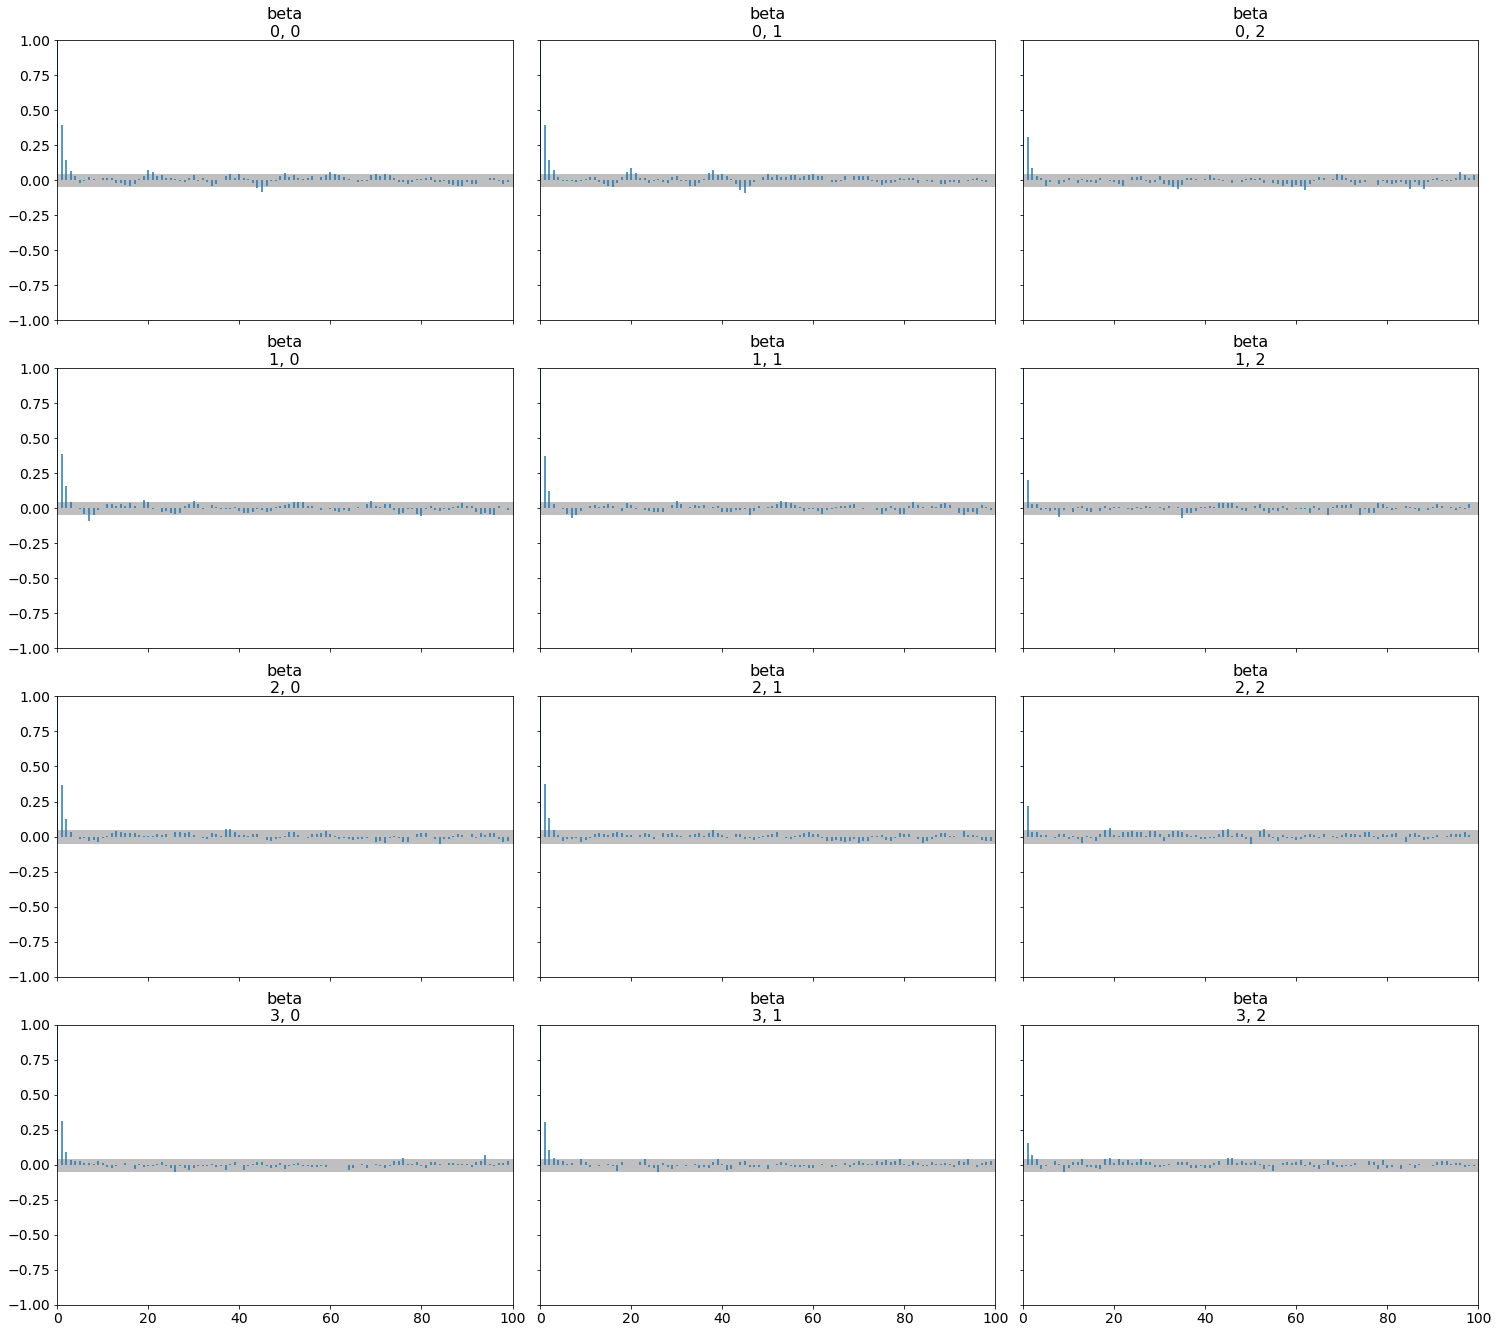

In [12]:
# Plot autocorreltion of the MCMC chains
az.plot_autocorr(fit,var_names=("beta"));

Autocorrelation plots show no pathologies with scores quickly decreasing to around 0

In [13]:
# Convert pystan fit object to IO for Arviz functions.
idata = az.from_pystan(posterior=fit,posterior_model = sm, 
                       posterior_predictive=['yrep'],
                       observed_data= 'y')

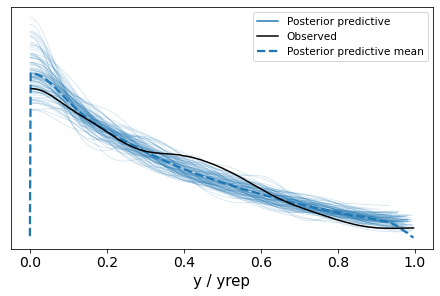

In [14]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples= 100);

As the posterior predictive check show the Beta likelihood model fit the data (overclaiming proportion scores) more effectively compared too the normal likelihood model fitted to the same data (see, the multiple regression notebook example).

# Reporting the results of the Bayesian Beta egression

# References

Schmettow, M. (2021). *New statistics for design researchers*. Springer.

Smithson, M., & Verkuilen, J. (2006). A better lemon squeezer? Maximum-likelihood regression with beta-distributed dependent variables. Psychological methods, 11(1), 54.